In [1]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnTimePlannerSys, SpacetimeKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage
import numpy as np

import matplotlib.pyplot as plt

# PyLQR: Position/Orientation/Time planner or tracker example

In this example, we will present how to use iLQR to plan or track a system that has for target space $\mathbf{\mu}_t$ :

* position ``[x,y,z]``
* orientation (in quaternion) ``[w,x,y,z]``
* Time ``t``

$$
    \mathbf{\mu}_t = \lbrack x \ y \ z \ w \ x \ y \ z \ t \rbrack^\top
$$

For state space $\mathbf{x}_t$ (it is a latent space):

* joint positions $\mathbf{q}$
* Time ``t``

$$
    \mathbf{x}_t = \lbrack \mathbf{q}^\top \ t \rbrack^\top
$$

For command space $\mathbf{u}_t$:

* joint velocities $\mathbf{\dot{q}}$
* square root of delta t $ \sqrt{\text{dt}} $ (to avoid negative delta t)

$$
    \mathbf{u}_t = \lbrack \mathbf{\dot{q}}^\top \ \sqrt{\text{dt}} \rbrack^\top
$$

<span style="color:red">**The target space is get with the forward kinematics function with $\mathbf{x}_t$  as robot configuration**</span>

In [2]:
# Global task variables
dof = 7
nb_state_var = dof + 1 # [q,t]
nb_ctrl_var = dof + 1 # [dq,sqrt(dt)]
nb_fox_var = 8 # [pos,orn,t]
horizon=100

## Definition of the robot object

The first to do is to create the abstraction of the robot that we want to control. Here we will a robot's abstraction based on the KDL library. The ``KDLRobot`` class requires:

* An URDF file describing the robot that we want to use.
* The name of the base frame in the URDF
* The name of the tip frame in the URDF
* Initial joint configuration

This class will *simulate* the kinematics evolution of the Panda robot in function of the control command that we will send to him.

In [3]:
PATH_TO_URDF = "model.urdf"
BASE_FRAME = "panda_link0"
TIP_FRAME = "panda_tip"
q0 = [0]*dof
dq0 = [0]*dof

qMax = np.array([np.pi]*dof)*10
dqMax = np.array([10]*dof)
rbt = KDLRobot(PATH_TO_URDF,BASE_FRAME,TIP_FRAME,q0,dq0)

## Task & system definition

Now that we have an object simulating the kinematics of our robot, we have to build a system object that will describe the task that we want to perform. Here since we are looking to optimize position,orientation and time
we will instantiate an object of type ``PosOrnTimePlannerSys``. To create this object, we need:

* A list of Keypoints (here ``SpacetimeKeypoint``), each element in this list represents a keypoint, it contains:
  * A position target
  * An orientation target
  * A continuous time target
  * A precision matrix
  * A discrete time value (discrete time of occurence)
* Joint limits/special end-effector transforms. Optional (see below).
* Some extra-information about the system:
  * Control command penalty (rfactor)
  * Horizon of the problem
  * Order of the system (in this example it's 1)

In [4]:
target1_pos = np.array([0.554121212377707,      #x (position)
            -0.01575049935289518,  #y (position)
            0.38295604872511507])   #z (position)

target1_orn = np.array([0.014042440828406944,  #w (quaternion)
            0.915047647731553,     #x (quaternion)
            0.4024820607528928,    #y (quaternion)
            0.022333898196169735])  #z (quaternion)

Qtarget1 = np.diag([1, # Tracking the x position
            1, # Tracking the y position
            1, # Tracking the z position
            .1, # Tracking orientation around x axis
            .1, # Tracking orientation around y axis
            .1, # Tracking orientation around z axis
            0]) # Tracking continuous time

target1_continuous_time = 2
target1_discrete_time = horizon//2 - 1

keypoint_1 = SpacetimeKeypoint(target1_pos,target1_orn,Qtarget1,target1_continuous_time,target1_discrete_time)

# Similarly for the second target:

target2_pos = np.array([0.254121212377707,
            -0.07575049935289518,
            0.13170744424127526])

target2_orn = np.array([0.029927010072216945,
            0.9121514607332729,
            0.4087591864532181,
            0.00011933313484481926])

Qtarget2 = np.diag([1,
            1,
            1,
            .1,
            .1,
            .1,
            .1]) 

target2_continuous_time = 5
target2_discrete_time = horizon -1

keypoint_2 = SpacetimeKeypoint(target2_pos,target2_orn,Qtarget2,target2_continuous_time,target2_discrete_time)

cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist() # Each control signals have a penalty of 1e-5

keypoints = [keypoint_1,keypoint_2]

# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
# sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,horizon,1,dt)
sys = PosOrnTimePlannerSys(rbt,keypoints,cmd_penalties,qMax,-qMax,dqMax,-dqMax,horizon,1) 

## Solver definition

Now that the robot and system object are defined, we will define two different solvers to optimize the system:

* A Batch Iterative LQR with control primitives.
* A standard iLQR

Because of the batch formulation, the first one can only be used as a planning algorithm. 
Seconde one can either be used as planning or tracking algorithm (by using either the resulting state sequences or the control gains).

Batch solution use a library of primitives to build the control command:

$$
    \mathbf{u} = \Psi \mathbf{w}
$$

Where $\mathbf{w}$ is the weight of each control primitives. To build the primitives, you can use the ``PyLQR.utils.primitives`` module.

In [5]:
u0_t = np.array([0]*(nb_ctrl_var-1) + [0.01])
u0 = np.tile(u0_t,horizon-1)

K = 2
psi = primitives.build_psi_unitstep(horizon-1,K)
PSI = np.kron(psi,np.identity(nb_ctrl_var))

# For the batch solution, if you want to use of diagonal elements for Q or special construction of mu,
# you can override targets and precisions set in the system by replacing the 2 lines below by what you want.
mu = sys.get_mu_vector(False)
Q = sys.get_Q_matrix(False)

planner1 = BatchILQRCP(sys,PSI)
planner2 = ILQRRecursive(sys)
planner3 = BatchILQR(sys)

In [6]:
cb = PythonCallbackMessage() # callback to notify python code of the solver evolution

In [7]:
%%time
U1 = planner1.solve(20,u0,True,cb)
U1 = U1.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X1 = np.zeros((horizon,nb_state_var))
F_X1 = np.zeros((horizon,nb_fox_var))

X1[0] = np.hstack(( rbt.get_q() , 0 ))
F_X1[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn(),0))
t = 0
for i in range(horizon-1):
    ut = U1[i,:-1]
    dt = U1[i,-1]**2
    
    rbt.send_vel(dt,ut,True)
    t += dt
    
    X1[i+1] = np.hstack(( rbt.get_q() , t ))
    F_X1[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn(), t))

Iteration 1, Cost: 3.41273, alpha= 0.0625
Iteration 2, Cost: 1.12468, alpha= 0.25
Iteration 3, Cost: 0.438064, alpha= 0.5
Iteration 4, Cost: 0.180731, alpha= 1
Iteration 5, Cost: 0.165212, alpha= 0.5
Iteration 6, Cost: 0.0525568, alpha= 0.5
Iteration 7, Cost: 0.0113259, alpha= 0.5
Iteration 8, Cost: 0.00595602, alpha= 1
Iteration 9, Cost: 0.000825001, alpha= 0.5
Iteration 10, Cost: 0.000710878, alpha= 1
Iteration 11, Cost: 0.000671207, alpha= 0.5
Iteration 12, Cost: 0.000669919, alpha= 1
Iteration 13, Cost: 0.000663674, alpha= 0.5
Iteration 14, Cost: 0.000661334, alpha= 1
Iteration 15, Cost: 0.000659581, alpha= 0.5
Iteration 16, Cost: 0.000657344, alpha= 1
Iteration 17, Cost: 0.000657251, alpha= 0.5
Iteration 18, Cost: 0.000655372, alpha= 0.5
Iteration 19, Cost: 0.000654564, alpha= 1
Iteration 20, Cost: 0.000653455, alpha= 0.25
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 105 ms


In [8]:
%%time
X2,F_X2,U2,K2,k2 = planner2.solve(u0.reshape((-1,nb_ctrl_var)),20,True,True,cb)

Iteration 1, Cost: 1.20051, alpha= 0.5, time= 0.00136176
Iteration 2, Cost: 0.918933, alpha= 0.125, time= 0.00221942
Iteration 3, Cost: 0.520269, alpha= 0.25, time= 0.00177305
Iteration 4, Cost: 0.295166, alpha= 0.25, time= 0.00175532
Iteration 5, Cost: 0.0856217, alpha= 0.5, time= 0.00139879
Iteration 6, Cost: 0.0492506, alpha= 0.25, time= 0.00176572
Iteration 7, Cost: 0.0268716, alpha= 0.25, time= 0.00179942
Iteration 8, Cost: 0.00829871, alpha= 0.5, time= 0.00134771
Iteration 9, Cost: 0.00689693, alpha= 1, time= 0.000933743
Iteration 10, Cost: 0.000608163, alpha= 1, time= 0.000933584
Iteration 11, Cost: 3.22939e-05, alpha= 1, time= 0.00109301
Iteration 12, Cost: 2.98669e-05, alpha= 1, time= 0.000931099
Iteration 13, Cost: 2.98666e-05, alpha= 0.25, time= 0.00176792
Iteration 14, Cost: 2.98666e-05, alpha= 0.000976562, time= 0.00499051
CPU times: user 26.9 ms, sys: 0 ns, total: 26.9 ms
Wall time: 25.8 ms


In [9]:
%%time
U3 = planner3.solve(40,u0,True,cb)
U3 = U3.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X3 = np.zeros((horizon,nb_state_var))
F_X3 = np.zeros((horizon,nb_fox_var))

X3[0] = np.hstack(( rbt.get_q() , 0 ))
F_X3[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn(),0))
t = 0
for i in range(horizon-1):
    ut = U3[i,:-1]
    dt = U3[i,-1]**2
    
    rbt.send_vel(dt,ut,True)
    t += dt
    
    X3[i+1] = np.hstack(( rbt.get_q() , t ))
    F_X3[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn(), t))

Iteration 1, Cost: 3.41273, alpha= 0.0625
Iteration 2, Cost: 1.13176, alpha= 0.25
Iteration 3, Cost: 0.441169, alpha= 0.0625
Iteration 4, Cost: 0.326859, alpha= 0.125
Iteration 5, Cost: 0.244332, alpha= 0.25
Iteration 6, Cost: 0.128937, alpha= 0.0625
Iteration 7, Cost: 0.101379, alpha= 0.25
Iteration 8, Cost: 0.100315, alpha= 0.5
Iteration 9, Cost: 0.0885511, alpha= 0.000976562
Iteration 10, Cost: 0.0885739, alpha= 0.000976562
Iteration 11, Cost: 0.0885965, alpha= 0.000976562
Iteration 12, Cost: 0.0886191, alpha= 0.000976562
Iteration 13, Cost: 0.0886415, alpha= 0.000976562
Iteration 14, Cost: 0.0886639, alpha= 0.000976562
Iteration 15, Cost: 0.0886862, alpha= 0.000976562
Iteration 16, Cost: 0.0887084, alpha= 0.000976562
Iteration 17, Cost: 0.0887305, alpha= 0.000976562
Iteration 18, Cost: 0.0887524, alpha= 0.000976562
Iteration 19, Cost: 0.0887743, alpha= 0.000976562
Iteration 20, Cost: 0.0887961, alpha= 0.000976562
Iteration 21, Cost: 0.0888178, alpha= 0.000976562
Iteration 22, Cost:

<IPython.core.display.Javascript object>


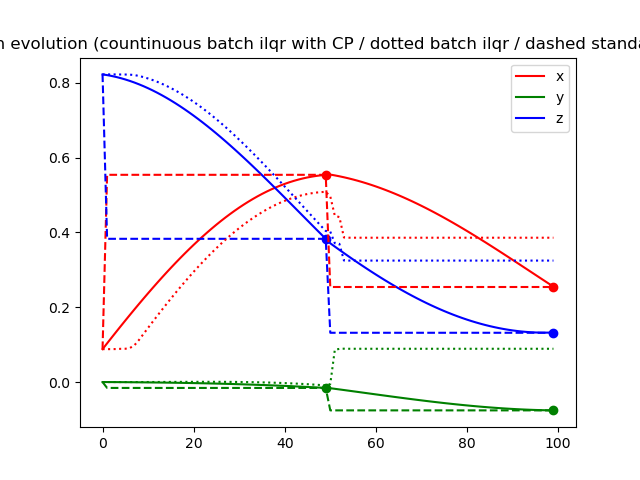

In [10]:
%matplotlib notebook
F_X2 = np.asarray(F_X2)

plt.figure()
plt.title('Position evolution (countinuous batch ilqr with CP / dotted batch ilqr / dashed standard iLQR)')
plt.plot(F_X1[:,0],c='r',label='x')
plt.plot(F_X1[:,1],c='g',label='y')
plt.plot(F_X1[:,2],c='b',label='z')

plt.plot(F_X2[:,0],c='r',linestyle='dashed')
plt.plot(F_X2[:,1],c='g',linestyle='dashed')
plt.plot(F_X2[:,2],c='b',linestyle='dashed')

plt.plot(F_X3[:,0],c='r',linestyle='dotted')
plt.plot(F_X3[:,1],c='g',linestyle='dotted')
plt.plot(F_X3[:,2],c='b',linestyle='dotted')

plt.scatter(target1_discrete_time,target1_pos[0],c='r')
plt.scatter(target1_discrete_time,target1_pos[1],c='g')
plt.scatter(target1_discrete_time,target1_pos[2],c='b')

plt.scatter(target2_discrete_time,target2_pos[0],c='r')
plt.scatter(target2_discrete_time,target2_pos[1],c='g')
plt.scatter(target2_discrete_time,target2_pos[2],c='b')

plt.legend()

<IPython.core.display.Javascript object>


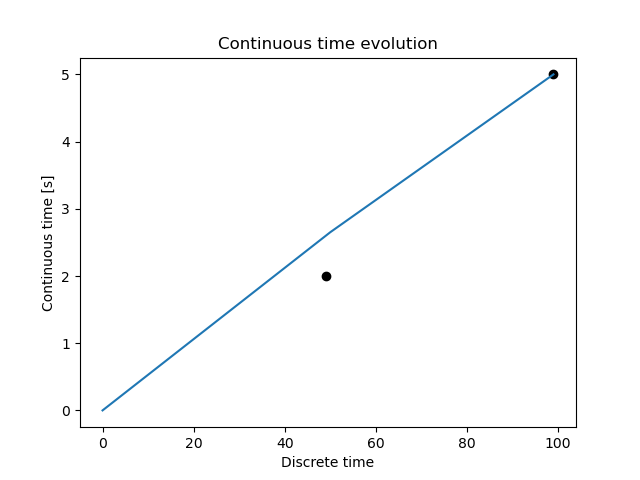

In [11]:
plt.figure()
plt.title("Continuous time evolution")
plt.xlabel("Discrete time")
plt.ylabel("Continuous time [s]")
plt.scatter(target1_discrete_time,target1_continuous_time,c='black')
plt.scatter(target2_discrete_time,target2_continuous_time,c='black')
plt.plot(F_X1[:,-1])

**As you can see, for space time problems, standard iLQR does not offer a good enough solution. That's why it is not recommended to use standard iLQR with it. Anyway, because of the time optimization, you can not use it directly as a controllers and computation time is quite similar in both scenarios.**